# (Title to be decided)

*This is the file for the code of our group assignment. Under development.*

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras_tuner.tuners import BayesianOptimization

# gpu acceleration, would cause an error when running without a cuda gpu
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Set up a time calculation method for collecting time used during running the code:

In [2]:
# Variable for storing recorded timestamp
timer_record = 0

# Method for updating timer (setting the starting time)
def timer_start():
    global timer_record
    timer_record = time.time()

# Method for printing the time since last update
#
# the second num will be returned
def timer_read(print_result=True):
    second_passed = time.time() - timer_record
    if print_result:
        print(f"{second_passed:.3}s passed")
        return
    return second_passed


## 1. Read Data from External File

Read data in external files. For convenience, the original `.pcapng` file has been converted into `.json` and `.csv` with Wireshark.

In [3]:
# Read the JSON including all details of packets
#   errors="surrogateescape" to pass the encoding errors raised by contents in HTTP packets
with open("./data/traffic.json", "r", encoding="utf-8", errors="surrogateescape") as f:
    dataset_json=json.load(f)
    print(f"{len(dataset_json)} packets read")

# print one for checking
#dataset_json[0]

10625 packets read


## 2. Data Preprocessing

### 2.1 Extract dataset labels and encoding

In [4]:
# Extract labels(y) from JSON
dataset_y = np.array(list(map(
    lambda packet_json: (packet_json["_source"]["layers"]["pkt_comment"]["frame.comment"]).split(",")[1], 
    dataset_json
)))

print(f"Labels include {np.unique(dataset_y)}")
print(dataset_y.shape)

Labels include ['china' 'india' 'us']
(10625,)


### 2.2 Extract features

In [5]:
# Extract source IP, source IP host, destination IP and destination IP host from dataset
dataset_X_ip_src = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.src"], 
    dataset_json
)))
dataset_X_ip_src_host = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.src_host"], 
    dataset_json
)))
dataset_X_ip_dst = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.dst"], 
    dataset_json
)))
dataset_X_ip_dst_host = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.dst_host"], 
    dataset_json
)))

# print first ones for checking
print(dataset_X_ip_src[0])
print(dataset_X_ip_src_host[0])
print(dataset_X_ip_dst[0])
print(dataset_X_ip_dst_host[0])


10.11.1.3
10.11.1.3
8.8.8.8
dns.google


### 2.3 Check data sanity and deal with missing fields

In [6]:
# Data sanity check
pattern_not_ipv4 = re.compile(r"(?!((\b25[0-5]|\b2[0-4][0-9]|\b[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}))")
pattern_not_ipv4_nor_domain = re.compile(r"(?!((\b25[0-5]|\b2[0-4][0-9]|\b[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3})|[-_0-9a-zA-Z]+\.[-_0-9a-zA-Z]+)")

print("Source/dest IP not an IPv4 address:")
print(list(filter(pattern_not_ipv4.match, dataset_X_ip_src)))
print(list(filter(pattern_not_ipv4.match, dataset_X_ip_dst)))
print("Source/dest host not an IPv4 nor a domain:")
print(list(filter(pattern_not_ipv4_nor_domain.match, dataset_X_ip_src_host)))
print(list(filter(pattern_not_ipv4_nor_domain.match, dataset_X_ip_dst_host)))

print()

# Fill the missing `dst.host`
#
# Find "no-data" rows
missing_dst_host_indexes = np.where(dataset_X_ip_dst_host=='no-data')[0]
print(f"Indexes of rows with missing 'dst.host': {missing_dst_host_indexes}")

# Fill the field with the IP address in `dst`, following the way of other rows
for i in missing_dst_host_indexes:
    dataset_X_ip_dst_host[i] = dataset_X_ip_dst[i]

print("Missing 'dst.host' filled")

Source/dest IP not an IPv4 address:
[]
[]
Source/dest host not an IPv4 nor a domain:
[]
['no-data', 'no-data']

Indexes of rows with missing 'dst.host': [960 964]
Missing 'dst.host' filled


### 2.4 Bi-gram for similarity between IPs and domains

In [7]:
# bi-gram for similar IP and hostnames
bigram_vec = CountVectorizer(ngram_range=(2, 2), token_pattern=r"(?u)[^.]+")
dataset_X_ip_src_bg = bigram_vec.fit_transform(dataset_X_ip_src).toarray()
dataset_X_ip_src_host_bg = bigram_vec.fit_transform(dataset_X_ip_src_host).toarray()
dataset_X_ip_dst_bg = bigram_vec.fit_transform(dataset_X_ip_dst).toarray()
dataset_X_ip_dst_host_bg = bigram_vec.fit_transform(dataset_X_ip_dst_host).toarray()

print(dataset_X_ip_src_bg.shape)
print(dataset_X_ip_src_host_bg.shape)
print(dataset_X_ip_dst_bg.shape)
print(dataset_X_ip_dst_host_bg.shape)

dataset_X = np.concatenate((
    dataset_X_ip_src_bg, 
    dataset_X_ip_src_host_bg,
    dataset_X_ip_dst_bg, 
    dataset_X_ip_dst_host_bg), axis=1)

print("")
print(dataset_X.shape)


(10625, 1402)
(10625, 867)
(10625, 1629)
(10625, 1059)

(10625, 4957)


### 2.5 Normalization

In [8]:
# Normalization
dataset_X = MinMaxScaler().fit_transform(dataset_X)
print(dataset_X.shape)

(10625, 4957)


### 2.6 Principal Component Analysis (PCA)

In [9]:
# # PCA - check the 95% with figure
# #
# # This part is not necessary for the main process and
# # can be commented out to save time
# pca = PCA()
# pca.fit(dataset_X)
# pca_cumsum = np.cumsum(pca.explained_variance_ratio_)

# plt.figure()
# plt.axis([0, dataset_X.shape[1], 0, 1]) 
# plt.plot(pca_cumsum)
# plt.axhline(y=0.95,color='red')
# plt.xlabel("dimensions")
# plt.ylabel("explained variance")
# plt.grid(True)
# plt.show()

In [10]:
timer_start()

# Apply PCA for compression
pca = PCA(n_components=0.95)
dataset_X = pca.fit_transform(dataset_X)

print(dataset_X.shape)
timer_read()

(10625, 650)
66.3s passed


### 2.7 Dataset split

In [11]:
# Split the dataset into training set and testing set
train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(7968, 650)
(7968,)
(2657, 650)
(2657,)


## 3. Model Training

### 3.1 Logistic Regression

#### 3.1.1 Parameter Tuning

(This part is **not** necessary for generating the final result and can be commented out to save time)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the model
lr = LogisticRegression(max_iter=10000)

# Search for the best C value using grid search CV
lr_param_grid = {
    'C': np.logspace(-2, 2, 5),
}
lr_grid_search = GridSearchCV(lr, lr_param_grid, cv=5, scoring='accuracy', verbose=4)
lr_grid_search.fit(train_X, train_y)

# Print the best parameter and score
print("Best Parameter:    ", lr_grid_search.best_params_)
print("Score of the best: ", lr_grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ............................C=0.01;, score=0.807 total time=   0.1s
[CV 2/5] END ............................C=0.01;, score=0.819 total time=   0.1s
[CV 3/5] END ............................C=0.01;, score=0.801 total time=   0.1s
[CV 4/5] END ............................C=0.01;, score=0.813 total time=   0.1s
[CV 5/5] END ............................C=0.01;, score=0.804 total time=   0.1s
[CV 1/5] END .............................C=0.1;, score=0.871 total time=   0.3s
[CV 2/5] END .............................C=0.1;, score=0.857 total time=   0.3s
[CV 3/5] END .............................C=0.1;, score=0.866 total time=   0.4s
[CV 4/5] END .............................C=0.1;, score=0.872 total time=   0.3s
[CV 5/5] END .............................C=0.1;, score=0.870 total time=   0.3s
[CV 1/5] END .............................C=1.0;, score=0.891 total time=   0.7s
[CV 2/5] END .............................C=1.0;,

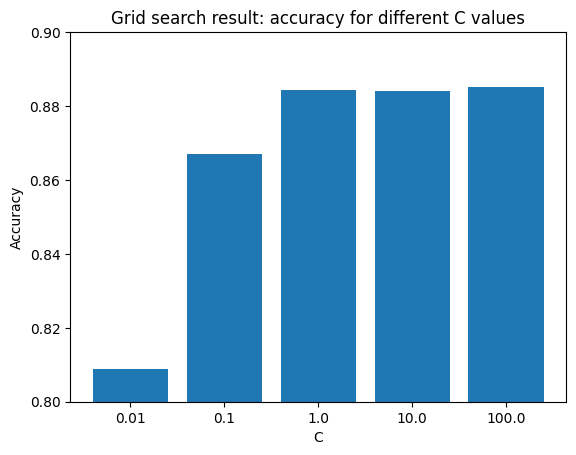

In [13]:
# Print the scores of all tested potential params
lr_grid_param_values = []
lr_grid_precision_values = []
for i, params in enumerate(lr_grid_search.cv_results_['params']):
    lr_grid_param_values.append(params['C'])
    lr_grid_precision_values.append(lr_grid_search.cv_results_['mean_test_score'][i])

# Plot the precision values for each parameter value
plt.bar(range(len(lr_grid_precision_values)), lr_grid_precision_values, tick_label=lr_grid_param_values)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 0.9])
plt.title('Grid search result: accuracy for different C values')
plt.show()

Based on the bar chart, scores for 1, 10 and 100 are close to each other with few differences. `C=1` is chosen with its high performance and the lowest time consumption between the three values, who is also the default value and a frequently used one in common practice,

#### 3.1.2 Model Training

In [14]:
timer_start()

lr = LogisticRegression(C=1.0, max_iter=1000)
lr.fit(train_X, train_y)

timer_read()

1.41s passed


### 3.2 Support Vector Machine (SVM)

#### 3.2.1 Parameter Tuning

(This part is **not** necessary for generating the final result and can be commented out to save time)

In [15]:
from sklearn.svm import SVC  # Support Vector Classifier

# Grid_search for SVM
svm = SVC()
svm_param_grid = {
    'C': np.logspace(-2, 2, 5),
    'kernel':['linear','rbf','sigmoid']
}

svm_grid_search = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy', verbose=4)
svm_grid_search.fit(train_X, train_y)

# Print the best parameter and score
print("Best Parameter:    ", svm_grid_search.best_params_)
print("Score of the best: ", svm_grid_search.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.774 total time=   8.9s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.789 total time=   7.9s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.767 total time=   7.8s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.765 total time=   7.9s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.765 total time=   8.2s
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.679 total time=  17.8s
[CV 2/5] END ................C=0.01, kernel=rbf;, score=0.707 total time=  18.0s
[CV 3/5] END ................C=0.01, kernel=rbf;, score=0.687 total time=  17.6s
[CV 4/5] END ................C=0.01, kernel=rbf;, score=0.692 total time=  19.5s
[CV 5/5] END ................C=0.01, kernel=rbf;, score=0.684 total time=  18.4s
[CV 1/5] END ............C=0.01, kernel=sigmoid;, score=0.730 total time=  16.6s
[CV 2/5] END ............C=0.01, kernel=sigmoid;

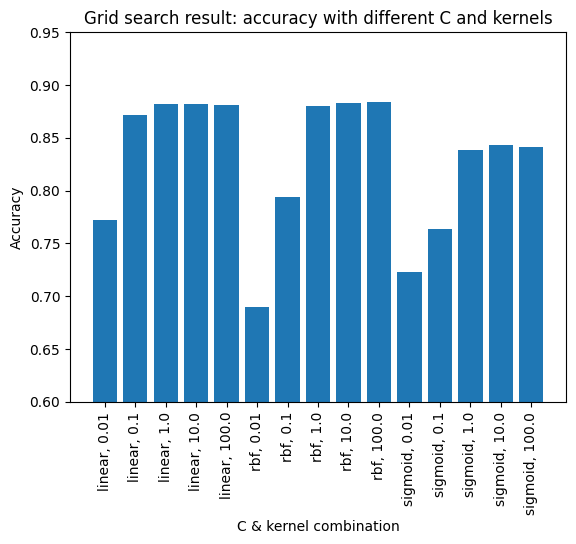

In [16]:
svm_grid_results = []
for i, params in enumerate(svm_grid_search.cv_results_['params']):
    svm_grid_results.append({
        "param": f"{params['kernel']}, {params['C']}",
        "score": svm_grid_search.cv_results_['mean_test_score'][i]
    })

# Sort the results by params
svm_grid_results = sorted(svm_grid_results, key=lambda a:a["param"])


# Plot the accuracy values for each parameter value
svm_grid_param_values = []
svm_grid_accuracy_values = []
for r in svm_grid_results:
    svm_grid_param_values.append(r["param"])
    svm_grid_accuracy_values.append(r["score"])

plt.bar(range(len(svm_grid_param_values)), svm_grid_accuracy_values, tick_label=svm_grid_param_values)
plt.xlabel('C & kernel combination')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.ylim([0.6, 0.95])
plt.title('Grid search result: accuracy with different C and kernels')
plt.show()

Based on the grid search result, `C=100` and `kernel="rbf"` is chosen for the SVM model with its best accuracy.

#### 3.2.2 Model Training

In [17]:
timer_start()

svm_model = SVC(kernel = 'rbf', C = 100)
svm_model.fit(train_X, train_y)

timer_read()

6.96s passed


### 3.3 neural network

Data proccess

In [18]:
keras.backend.clear_session()

temp_train_y = pd.DataFrame(train_y, columns=['country'])
temp_train_y, uniques = pd.factorize(temp_train_y['country'], sort=True)
train_X_nn, validate_X, train_y_nn, validate_y = train_test_split(train_X, temp_train_y, random_state=114514, test_size=0.3)

train_y_nn = keras.utils.to_categorical(train_y_nn, 3).astype('int32')
validate_y = keras.utils.to_categorical(validate_y, 3).astype('int32')

print(train_X_nn.shape)
print(validate_X.shape)
print(train_y_nn.shape)
print(validate_y.shape)
print(uniques)

(5577, 650)
(2391, 650)
(5577, 3)
(2391, 3)
Index(['china', 'india', 'us'], dtype='object')


Define model

In [19]:
def build_optimizer(hp):
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, step=1e-5)
    if optimizer == 'adam':
        return keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'rmsprop':
        return keras.optimizers.RMSprop(learning_rate=lr)
    else:
        return keras.optimizers.SGD(learning_rate=lr, momentum=hp.Float('momentum', min_value=0, max_value=0.9, step=0.02))

def build_model(hp):
    model = keras.models.Sequential(keras.layers.InputLayer(input_shape=[train_X.shape[1]]))
    model.add(keras.layers.Dense(hp.Int('neurons1', min_value=1, max_value=300, step=5),
                                 activation=hp.Choice('actv1', ['relu', 'tanh', 'sigmoid']),
                                 kernel_initializer='he_normal'))
    if hp.Boolean('second_layer', True):
        model.add(keras.layers.Dropout(hp.Float('dropout1', min_value=0, max_value=0.3, step=0.02)))
        model.add(keras.layers.Dense(hp.Int('neurons2', min_value=1, max_value=300, step=5),
                                     activation=hp.Choice('actv2', ['relu', 'tanh', 'sigmoid']),
                                     kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(3, activation="softmax"))

    model.compile(loss='categorical_crossentropy',
                  optimizer=build_optimizer(hp),
                  metrics=['accuracy'])
    return model

Bayesion optimization

In [20]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    project_name='neural_network_optimize'
)

tuner.search(x=train_X_nn, y=train_y_nn, epochs=35, validation_data=(validate_X, validate_y))

best_hps = tuner.get_best_hyperparameters()[0]
print(f'Best hyperparameters: {best_hps.values}')


INFO:tensorflow:Reloading Tuner from .\neural_network_optimize\tuner0.json
INFO:tensorflow:Oracle triggered exit
Best hyperparameters: {'neurons1': 281, 'actv1': 'relu', 'second_layer': False, 'dropout1': 0.02, 'neurons2': 131, 'actv2': 'relu', 'optimizer': 'adam', 'learning_rate': 6e-05}


Model Trainning

In [21]:
optimized_model = build_model(best_hps)
history = optimized_model.fit(train_X_nn, train_y_nn, epochs=35,
                     validation_data=(validate_X, validate_y))
optimized_model.summary()

Epoch 1/35
175/175 [==============================] - 2s 5ms/step - loss: 1.0602 - accuracy: 0.4653 - val_loss: 1.0051 - val_accuracy: 0.6403
Epoch 2/35
175/175 [==============================] - 1s 3ms/step - loss: 0.9511 - accuracy: 0.7300 - val_loss: 0.9091 - val_accuracy: 0.7599
Epoch 3/35
175/175 [==============================] - 1s 3ms/step - loss: 0.8527 - accuracy: 0.7963 - val_loss: 0.8190 - val_accuracy: 0.7913
Epoch 4/35
175/175 [==============================] - 1s 3ms/step - loss: 0.7606 - accuracy: 0.8189 - val_loss: 0.7350 - val_accuracy: 0.8051
Epoch 5/35
175/175 [==============================] - 1s 3ms/step - loss: 0.6767 - accuracy: 0.8297 - val_loss: 0.6594 - val_accuracy: 0.8210
Epoch 6/35
175/175 [==============================] - 1s 3ms/step - loss: 0.6029 - accuracy: 0.8413 - val_loss: 0.5945 - val_accuracy: 0.8302
Epoch 7/35
175/175 [==============================] - 1s 3ms/step - loss: 0.5408 - accuracy: 0.8474 - val_loss: 0.5400 - val_accuracy: 0.8377
Epoch 

Output

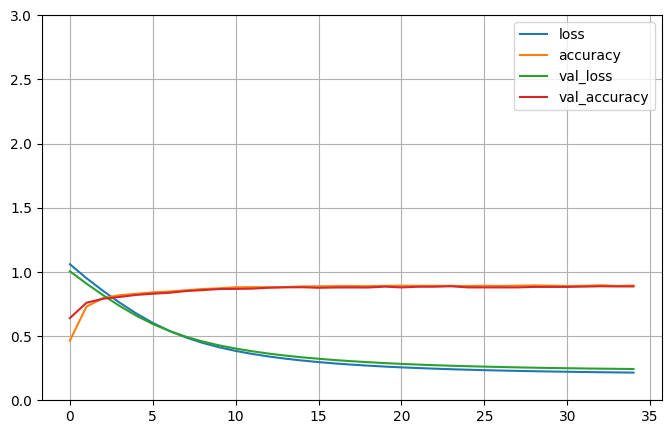

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

## 4. Model Testing and Comparison

### 4.1 Test Results

In [23]:
# NOTE
# TODO: REMOVE BEFORE SUBMIT

# For team members - Structure of a result dict (example):
#
# Add additional key/values if feel necessary

example_lr_results = {
    "f1_score": 0.12,
    "recall": 0.34,
    "precision": 0.56,
    "accuracy": 0.78,

    "by_label": {  # VALUES FOR DIFFERENT COUNTRY CATEGORIES
        "labels": ['china', 'india', 'us'],  # country name labels, should be the same for every one
        "f1_score": [ 0.12, 0.34, 0.56],
        "recall": [ 0.12, 0.34, 0.56],
        "precision": [ 0.12, 0.34, 0.56],
    }
}



#### 4.1.1 Logistic Regression

In [24]:
# Make prediction on the test set
timer_start()

lr_y_pred = lr.predict(test_X)

timer_read()

0.004s passed


In [25]:
# Generate and save evaluation results

# Variable for storing the evaluation of logistic regression
lr_results={}

lr_results["f1_score"] = metrics.f1_score(test_y, lr_y_pred, average='macro')
lr_results["recall"] = metrics.recall_score(test_y, lr_y_pred, average='macro')
lr_results["precision"] = metrics.precision_score(test_y, lr_y_pred, average='macro')
lr_results["accuracy"] = metrics.accuracy_score(test_y, lr_y_pred)

lr_results["by_label"] = {}
lr_results["by_label"]["labels"] = np.sort(np.unique(dataset_y))  # for metric functions, all labels are used in sorted order
lr_results["by_label"]["f1_score"] = metrics.f1_score(test_y, lr_y_pred, average=None)
lr_results["by_label"]["recall"] = metrics.recall_score(test_y, lr_y_pred, average=None)
lr_results["by_label"]["precision"] = metrics.precision_score(test_y, lr_y_pred, average=None)

# Print formatted classification report
print(metrics.classification_report(test_y, lr_y_pred))

# Check the result dict
print()
print(lr_results)

              precision    recall  f1-score   support

       china       0.99      0.90      0.94       779
       india       0.85      0.90      0.87      1014
          us       0.85      0.87      0.86       864

    accuracy                           0.89      2657
   macro avg       0.90      0.89      0.89      2657
weighted avg       0.89      0.89      0.89      2657


{'f1_score': 0.891525848365471, 'recall': 0.8876977309817736, 'precision': 0.897376460122679, 'accuracy': 0.8878434324426044, 'by_label': {'labels': array(['china', 'india', 'us'], dtype='<U5'), 'f1_score': array([0.94339623, 0.87403846, 0.85714286]), 'recall': array([0.89858793, 0.8964497 , 0.86805556]), 'precision': array([0.9929078 , 0.85272045, 0.84650113])}}


#### 4.1.2 SVM

In [26]:
# Make prediction
timer_start()
svm_y_pred = svm_model.predict(test_X)
timer_read()

3.11s passed


In [27]:
# Evaluate the prediction
svm_results={}

svm_results["f1_score"] = metrics.f1_score(test_y, svm_y_pred, average='macro')
svm_results["recall"] = metrics.recall_score(test_y, svm_y_pred, average='macro')
svm_results["precision"] = metrics.precision_score(test_y, svm_y_pred, average='macro')
svm_results["accuracy"] = metrics.accuracy_score(test_y, svm_y_pred)

svm_results["by_label"] = {}
svm_results["by_label"]["labels"] = np.sort(np.unique(dataset_y))
svm_results["by_label"]["f1_score"] = metrics.f1_score(test_y, svm_y_pred, average=None)
svm_results["by_label"]["recall"] = metrics.recall_score(test_y, svm_y_pred, average=None)
svm_results["by_label"]["precision"] = metrics.precision_score(test_y, svm_y_pred, average=None)

# Print formatted classification report
print(metrics.classification_report(test_y, svm_y_pred))

# Check the result dict
print(svm_results)

              precision    recall  f1-score   support

       china       0.99      0.90      0.94       779
       india       0.81      0.99      0.89      1014
          us       0.97      0.81      0.88       864

    accuracy                           0.90      2657
   macro avg       0.92      0.90      0.90      2657
weighted avg       0.91      0.90      0.90      2657

{'f1_score': 0.9035277709755819, 'recall': 0.8960222974491762, 'precision': 0.9234380068511792, 'accuracy': 0.9010161836657885, 'by_label': {'labels': array(['china', 'india', 'us'], dtype='<U5'), 'f1_score': array([0.94078062, 0.88879004, 0.88101266]), 'recall': array([0.89730424, 0.9852071 , 0.80555556]), 'precision': array([0.98868458, 0.8095624 , 0.97206704])}}


#### 4.1.3 The Neural Network

In [56]:
timer_start()
nn_y_pred = optimized_model.predict(test_X)
nn_y_pred = np.argmax(nn_y_pred, axis=1)
nn_y_pred = nn_y_pred.astype(np.unicode_)
print(nn_y_pred)
for i in range(len(uniques)):
    n1 = str(i)
    n2 = uniques[i]
    index = (nn_y_pred == n1)
    nn_y_pred[index] = n2
timer_read()
nn_y_pred

84/84 [==============================] - 0s 2ms/step
['2' '1' '2' ... '2' '1' '1']
0.248s passed


array(['us', 'india', 'us', ..., 'us', 'india', 'india'], dtype='<U21')

In [57]:
nn_results={}

nn_results["f1_score"] = metrics.f1_score(test_y, nn_y_pred, average='macro')
nn_results["recall"] = metrics.recall_score(test_y, nn_y_pred, average='macro')
nn_results["precision"] = metrics.precision_score(test_y, nn_y_pred, average='macro')
nn_results["accuracy"] = metrics.accuracy_score(test_y, nn_y_pred)

nn_results["by_label"] = {}
nn_results["by_label"]["labels"] = np.sort(np.unique(dataset_y))
nn_results["by_label"]["f1_score"] = metrics.f1_score(test_y, nn_y_pred, average=None)
nn_results["by_label"]["recall"] = metrics.recall_score(test_y, nn_y_pred, average=None)
nn_results["by_label"]["precision"] = metrics.precision_score(test_y, nn_y_pred, average=None)

print(metrics.classification_report(test_y, nn_y_pred))
print(nn_results)

              precision    recall  f1-score   support

       china       0.99      0.90      0.94       779
       india       0.80      0.99      0.88      1014
          us       0.98      0.79      0.87       864

    accuracy                           0.90      2657
   macro avg       0.92      0.89      0.90      2657
weighted avg       0.91      0.90      0.90      2657

{'f1_score': 0.9007197889398685, 'recall': 0.893005095965005, 'precision': 0.9225999568649534, 'accuracy': 0.8980052691004893, 'by_label': {'labels': array(['china', 'india', 'us'], dtype='<U5'), 'f1_score': array([0.94291471, 0.88456435, 0.87468031]), 'recall': array([0.90115533, 0.98619329, 0.79166667]), 'precision': array([0.98873239, 0.80192462, 0.97714286])}}


### 4.2 Result Comparison

TODO